In [1]:
import spacy
import pandas as pd
import time
import json

pd.options.mode.chained_assignment = None 

# Approach 1: Extracting data from script with SpaCY pipeline
The first approach uses movie scripts. A script contains scene descriptions and dialogues, and can be useful when trying to identify the presence of explicit content. Each movie is assigned a score based on the amount of explicit content observed. Explicit content identification is done using a simple bag-of-words approach.

### Reading data

In [2]:
movie_names = []
with open('..//data//imsdb_sample.txt') as fp:
    for line in fp:
        movie_names.append(line.replace("\n",""))

In [3]:
movie_names[0:10]

['10 Things I Hate About You',
 '12',
 '12 and Holding',
 '12 Monkeys',
 '12 Years a Slave',
 '127 Hours',
 '1492: Conquest of Paradise',
 '15 Minutes',
 '17 Again',
 '187']

In [4]:
# Reading word lists
corpus1 = []
with open('..//data//bad_words.txt') as fp:
    for line in fp:
        corpus1.append(line.replace("\n",""))
        
with open('..//data//words.txt') as fp:
    text = fp.readlines()
    corpus2 = [x.strip().lower() for x in text[0].split(",")]


bad_words_corpus = set(corpus1 + corpus2)
print(len(bad_words_corpus))

2267


### Creating the SpaCy pipeline
Batch size set to 100 based on tests

#### The function call has been commented out to save on runtime since the output has been store in a JSON file that is being read a few cells below

In [5]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1050000

In [6]:
error_list = [] # helpful in avoiding file not found errors
def get_features(index,name):
    features = {}
    completed_list = [] # storing all words
    count = 0
    name_path = name
    name_path = name_path.replace(":","_")
    name_path = name_path.replace("?","_")
    path = path = "data//movie_scripts//Script_" + name_path + ".txt"
    
    try:
        with open(path) as fp:
            script=fp.readlines()
        pos = ['ADJ','NOUN','VERB']
        for doc in nlp.pipe(script, disable=["parser","lemmatizer","ner"], batch_size=100):
            for token in doc:
                token_type = token.pos_
                if token_type in pos:
                    completed_list.append(token.text.lower())
                    if token.text in bad_words_corpus:
                        count +=1
        features['index'] = index
        features['movie_name'] = name
        features['count'] = count
        features['words'] = completed_list
        
    except OSError:
        error_list.append(name)
    
    return features

In [7]:
# data = []

# start = time.time()

# for movie_index, name in enumerate(movie_names):
#     data.append(get_features(movie_index,name))    
#     if movie_index%100 == 0:
#         print("Processed: ",movie_index)
# end = time.time()
# print(end-start)

### Total runtime: ~26 minutes

#### Saving data to avoid re-running nlp pipeline

In [8]:
# with open('data//output_dataframe.txt', 'w') as fout:
#     json.dump(data , fout)

In [9]:
with open('..//data//output_dataframe.txt', 'r') as fin:
    data = json.load(fin)

In [10]:
len(data)

1093

In [11]:
movie_data = pd.DataFrame(data)
movie_data.head(20)

,index,movie_name,count,words
0,0.0,10 Things I Hate About You,348.0,"[things, hate, written, based, taming, padua, ..."
1,1.0,12,170.0,"[cut, red, convertible, driving, car, passes, ..."
2,2.0,12 and Holding,352.0,"[holding, written, 04.06.04, morning, twin, bo..."
3,3.0,12 Monkeys,541.0,"[original, screenplay, inspired, fade, face, y..."
4,4.0,12 Years a Slave,645.0,"[years, slave, written, close, black, hands, o..."
5,5.0,127 Hours,366.0,"[written, massive, crowd, sports, stadium, far..."
6,6.0,1492: Conquest of Paradise,390.0,"[conquest, fade, credits, music, start, man, e..."
7,7.0,15 Minutes,737.0,"[words, panning, words, side, plane, tray, tab..."
8,8.0,17 Again,255.0,"[written, senior, high, school, dusk, few, car..."
9,9.0,187,492.0,"[draft, purposes, pair, black, penny, loafers,..."


In [12]:
movie_data = movie_data.dropna()

### Calculating percentage of profanity in a movie script

In [13]:
movie_data['percent_profanity'] = (movie_data['count'] / movie_data['words'].str.len()) * 100
movie_data

,index,movie_name,count,words,percent_profanity
0,0.0,10 Things I Hate About You,348.0,"[things, hate, written, based, taming, padua, ...",5.392005
1,1.0,12,170.0,"[cut, red, convertible, driving, car, passes, ...",3.451777
2,2.0,12 and Holding,352.0,"[holding, written, 04.06.04, morning, twin, bo...",5.365036
3,3.0,12 Monkeys,541.0,"[original, screenplay, inspired, fade, face, y...",4.435517
4,4.0,12 Years a Slave,645.0,"[years, slave, written, close, black, hands, o...",6.136429
...,...,...,...,...,...
1088,1088.0,You Can Count On Me,230.0,"[count, shooting, draft, car, moving, shifting...",3.973739
1089,1089.0,You've Got Mail,237.0,"[got, based, corner, 2nd, revised, sense, cybe...",2.885669
1090,1090.0,Youth in Revolt,492.0,"[youth, written, comes, sound, deep, breaths, ...",5.413732
1091,1091.0,Zero Dark Thirty,444.0,"[written, hear, actual, recorded, emergency, c...",6.016260


In [14]:
# Fixing movie titles format for easier merge. Titles originally of the form (Abyss, The). Converting to (The Abyss)
connectors = ('The','A','An')
def fix_titles(row):
    item = row[1]
    if item.endswith(connectors):
        item_replace = item.split(' ')
        item_replace.insert(0,item_replace[-1])
        item_replace.pop(-1)
        item_replace = ' '.join(item_replace)[:-1]

        item_replace = item_replace.replace('_',":")

        return item_replace
    else:
        return item

In [15]:
movie_data['movie_name'] = movie_data['movie_name'].astype('str')
movie_data['movie_name'] = movie_data.apply(lambda x: fix_titles(x),axis=1)

### Reading IMDb data
After reading the script data and calculating the profanity scores, the next step is to merge it with the existing IMDb dataset which gives us the ability to compare the calculated profanity scores with the existing MPAA ratings.

In [16]:
df_1 =  pd.read_csv('..//data//IMDBdata_MainData.csv')
df_2 = pd.read_csv('..//data//IMDBdata_MainData2.csv')

In [17]:
imdb_data = pd.concat([df_1,df_2]).drop_duplicates(subset=['Title']).reset_index(drop=True)
imdb_data.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,tomatoURL
0,Code Name: K.O.Z.,2015,NOT RATED,13 Feb 2015,114 min,"Crime, Mystery",Celal Çimen,NaN,"Cem Kurtoglu, Hakan Ural, Hazim Körmükçü, Tolg...",A look at the 17-25 December 2013 corruption s...,...,1.6,"24,600",tt4458206,movie,NaN,NaN,NaN,NaN,True,NaN
1,Saving Christmas,2014,PG,14 Nov 2014,80 min,"Comedy, Family",Darren Doane,"Darren Doane, Cheston Hervey","Kirk Cameron, Darren Doane, Bridgette Cameron,...",Kirk is enjoying the annual Christmas party ex...,...,1.6,"12,686",tt4009460,movie,03 Nov 2015,"$2,778,297",IPD/Samuel Goldwyn Films,http://www.savingchristmas.com/,True,http://www.rottentomatoes.com/m/kirk_camerons_...
2,Superbabies: Baby Geniuses 2,2004,PG,27 Aug 2004,88 min,"Comedy, Family, Sci-Fi",Bob Clark,"Steven Paul (story), Gregory Poppen (screenplay)","Jon Voight, Scott Baio, Vanessa Angel, Skyler ...",A group of smart-talking toddlers find themsel...,...,2.0,"26,376",tt0270846,movie,04 Jan 2005,"$9,016,422",Sony,http://www.sonypictures.com/movies/superbabies...,True,http://www.rottentomatoes.com/m/super_babies_b...
3,Daniel der Zauberer,2004,NOT RATED,12 Aug 2004,81 min,"Comedy, Crime, Fantasy",Ulli Lommel,Ulli Lommel (screenplay),"Daniel Küblböck, Ulli Lommel, Rudolf Waldemar ...","Evil assassins want to kill Daniel Kublbock, t...",...,1.9,"13,060",tt0421051,movie,NaN,NaN,NaN,NaN,True,http://www.rottentomatoes.com/m/daniel_der_zau...
4,Manos: The Hands of Fate,1966,NOT RATED,15 Nov 1966,70 min,Horror,Harold P. Warren,Harold P. Warren (screenplay),"Tom Neyman, John Reynolds, Diane Adelson, Haro...",A family gets lost on the road and stumbles up...,...,1.9,"31,768",tt0060666,movie,07 Oct 2003,NaN,Sinister Cinema,NaN,True,http://www.rottentomatoes.com/m/manos-the-hand...


In [18]:
merged = movie_data.merge(imdb_data, left_on='movie_name',right_on='Title',how='inner')
merged.shape
# 715 rows.

(715, 32)

In [19]:
# Some movies have 'Year' format as YYYY-YYYY. Removing the second half and only keeping the first YYYY as release data
def fix_year(year):
    if '–' in str(year):
        year = year.split("–")[0]
    return year
merged.Year = merged['Year'].apply(lambda x: fix_year(x))
merged.Year = merged.Year.astype('int32')

In [20]:
# Making values uniiform

merged['Rated']= merged['Rated'].replace('TV-14', 'PG-13')
merged['Rated']= merged['Rated'].replace('TV-MA', 'R')
merged['Rated']= merged['Rated'].replace('TV-PG', 'PG')
merged['Rated']= merged['Rated'].replace('NC-17', 'R')
merged['Rated']= merged['Rated'].replace('TV-G', 'G')
merged['Rated']= merged['Rated'].replace('TV-Y', 'G')

#removing values which are not rated
merged = merged[merged.Rated != 'UNRATED']
merged = merged[merged.Rated != 'APPROVED']
merged = merged[merged.Rated != 'NOT RATED']

In [21]:
merged['Rated'].value_counts()

R         399
PG-13     225
PG         62
G          11
PASSED      1
Name: Rated, dtype: int64

### Visualizing profanity scores and trendline
The profanity percentage scores are aggregated over the years.

In [43]:
count_over_years = merged.groupby('Year')['percent_profanity'].mean().reset_index()
count_over_years.sort_values(by='Year',inplace=True)

Text(0.5, 1.0, 'Explicit content over Years')

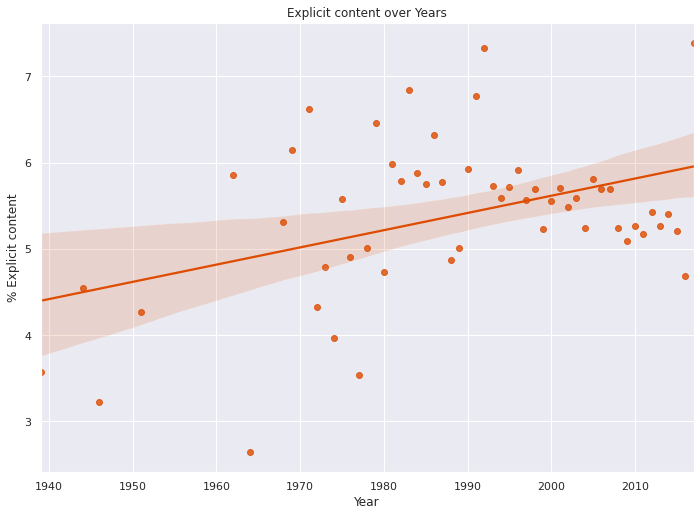

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.regplot(x=count_over_years['Year'],y=count_over_years['percent_profanity'],ci=95,)

fig = sns.regplot(x=count_over_years['Year'],y=count_over_years['percent_profanity'],ci=95,color=(221/255, 76/255, 0, 0.8))
plt.xlabel("Year")
plt.ylabel("% Explicit content")
plt.title("Explicit content over Years")

In [24]:
from scipy.stats import pearsonr
pearsonr(count_over_years['Year'],count_over_years['percent_profanity'])

(0.41841965918892476, 0.001477634407887239)

#### Results show a medium positive correlation, with a p-value of 0.0014. Statistically significant

# Approach 2: Using KIM scores
The second approach is more robust, and is based on numerical data. This approach uses ratings produced by Kids-in-Mind. Kids-in-Mind is an independent Internet information service and is not affiliated with any political organization of film studio (n=5407). Kids-in-Mind’s goal is to provide impartial reviews of films theatrically released in the  United States based on three metrics: Violence, sex, and language. This rating metric is more comprehensive as instead of having one letter category, each movie is rated on three 0-10 scales. The reviewers assign a score (referenced as KIM score for the rest of this article) based on the quality and intensity of content. A 0 is the lowest score possible, indicating no content of that particular type, and 10 indicates the most extreme content. The scores were summed up to create a single score as a way to identify the combined 
content across the three scales.

### Reading data
The ratings were scraped from the KIM website

In [25]:
# scraped KIM data
with open('..//data//kinds_in_mind_data.json', 'r') as f:
    kim = json.load(f)

In [26]:
kim_data = pd.DataFrame(kim.items(), columns=['Title', 'Rating'])
kim_data

,Title,Rating
0,Abandon,4.4.4
1,Abduction,4.5.5
2,Abominable,1.2.1
3,About A Boy,3.3.5
4,About Last Night,7.2.10
...,...,...
5402,The Ballad of Little Jo,6.5.3
5403,The Band’s Visit,5.2.5
5404,The Banger Sisters,7.2.6
5405,The Bank Job,8.8.7


### Data processing and cleaning
Merging the KIM ratings and the IMDb ratings dataset

In [27]:
temp_join = pd.merge(imdb_data,kim_data,on='Title')

In [45]:
temp_join.shape

(2641, 11)

In [28]:
temp_join = temp_join[['Title','Rated','Released','Genre','Plot','Rating']]
temp_join['Year'] = temp_join['Released'].str.split(' ',expand=True)[2]
temp_join = temp_join.dropna()
temp_join[['Sex','Violence','Language']] = temp_join['Rating'].str.split('.',expand=True)
temp_join['agg_score'] = temp_join['Sex'].astype(int) + temp_join['Violence'].astype(int) + temp_join['Language'].astype(int)

In [29]:
temp_join['Rated'].value_counts()

R            1122
PG-13        1051
PG            379
G              59
TV-14          14
UNRATED        10
APPROVED        6
TV-PG           6
TV-MA           6
NOT RATED       4
NC-17           2
TV-Y            1
TV-G            1
Name: Rated, dtype: int64

In [30]:
# Making values uniform

temp_join['Rated']= temp_join['Rated'].replace('TV-14', 'PG-13')
temp_join['Rated']= temp_join['Rated'].replace('TV-MA', 'R')
temp_join['Rated']= temp_join['Rated'].replace('TV-PG', 'PG')
temp_join['Rated']= temp_join['Rated'].replace('NC-17', 'R')
temp_join['Rated']= temp_join['Rated'].replace('TV-G', 'G')
temp_join['Rated']= temp_join['Rated'].replace('TV-Y', 'G')

#removing values which are not rated
temp_join = temp_join[temp_join.Rated != 'UNRATED']
temp_join = temp_join[temp_join.Rated != 'APPROVED']
temp_join = temp_join[temp_join.Rated != 'NOT RATED']

In [31]:
# Ignoring all values before 1992 because enough data isn't available
post92 = temp_join[temp_join['Year'].astype(int) > 1991]

### Calculating unweighted score and plotting
The first approach is to calculate the unweighted mean of KIM scores for each year. The idea is to see if there's a positive correlation between time and mean KIM scores. An increasing slope can indicate that the amount of explicit content has increased.

In [32]:
percentages = post92.groupby('Year')['Rated'].apply(lambda x: x.value_counts(normalize = True)).unstack()
percentages['unw_kim_score'] = post92.groupby('Year')['agg_score'].mean()
percentages

,G,PG,PG-13,R,unw_kim_score
Year,,,,,
1992,0.105263,0.105263,0.157895,0.631579,11.368421
1993,0.035714,0.357143,0.214286,0.392857,11.464286
1994,0.023810,0.166667,0.357143,0.452381,12.238095
1995,0.038462,0.057692,0.307692,0.596154,13.865385
1996,0.043478,0.144928,0.275362,0.536232,12.797101
1997,0.016129,0.129032,0.338710,0.516129,13.080645
1998,0.034483,0.114943,0.298851,0.551724,13.080460
1999,0.024390,0.097561,0.308943,0.569106,14.284553
2000,0.048000,0.112000,0.400000,0.440000,14.120000


<AxesSubplot:xlabel='Year', ylabel='unw_kim_score'>

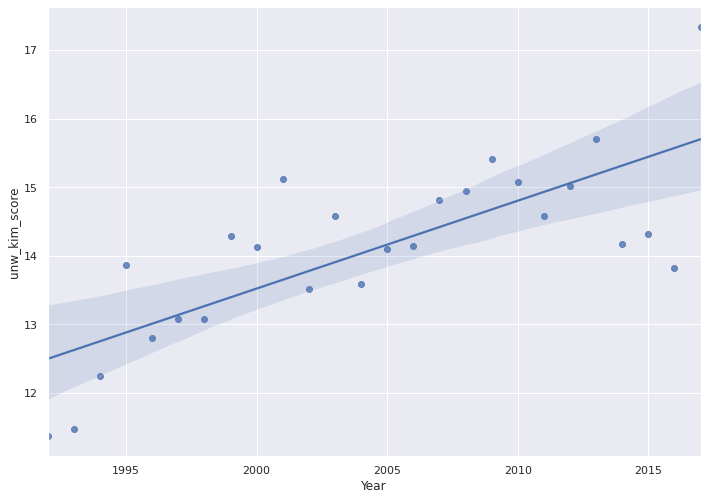

In [33]:
viz_df = percentages.reset_index()
viz_df['unw_kim_score'] = viz_df['unw_kim_score'].astype('float64')
viz_df['Year'] = viz_df['Year'].astype('int32')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.regplot(x=viz_df['Year'],y=viz_df['unw_kim_score'],ci=95)

### Calculating weighted score and plotting
There's one major caveat with the unweighted scores. Since the percentage distribution of movie ratings across years has varied, it's impossible to make any conclusions about KIM scores across years. For instance, a year with more R-rated movies will obviously have a higher KIM score as compared to a year with more PG rated movies. 

To solve this problem, the KIM scores are normalized by calculating the mean percentage distribution values across all years, and taking this value as the consistent percentage of film ratings for each year. By transforming the percentage distribution,the weighted KIM score was obtained.

In [34]:
# Normalizing
mean_percentage = dict(percentages.mean())
normalize_dict = percentages.to_dict()

In [35]:
def calculate_weighted_score(row,col_num):
    year = row[6]
    rated = row[1]
    weight = mean_percentage[rated] / normalize_dict[rated][year] 
    return row[col_num] * weight
post92['weighted_agg'] = post92.apply(calculate_weighted_score,args=[10], axis=1)

In [36]:
percentages['weighted_kim_score'] = post92.groupby('Year')['weighted_agg'].mean()

In [37]:
percentages

,G,PG,PG-13,R,unw_kim_score,weighted_kim_score
Year,,,,,,
1992,0.105263,0.105263,0.157895,0.631579,11.368421,10.824319
1993,0.035714,0.357143,0.214286,0.392857,11.464286,12.898595
1994,0.023810,0.166667,0.357143,0.452381,12.238095,12.361827
1995,0.038462,0.057692,0.307692,0.596154,13.865385,12.638741
1996,0.043478,0.144928,0.275362,0.536232,12.797101,12.460399
1997,0.016129,0.129032,0.338710,0.516129,13.080645,12.601274
1998,0.034483,0.114943,0.298851,0.551724,13.080460,12.408557
1999,0.024390,0.097561,0.308943,0.569106,14.284553,13.356841
2000,0.048000,0.112000,0.400000,0.440000,14.120000,14.207807


<AxesSubplot:xlabel='Year', ylabel='weighted_kim_score'>

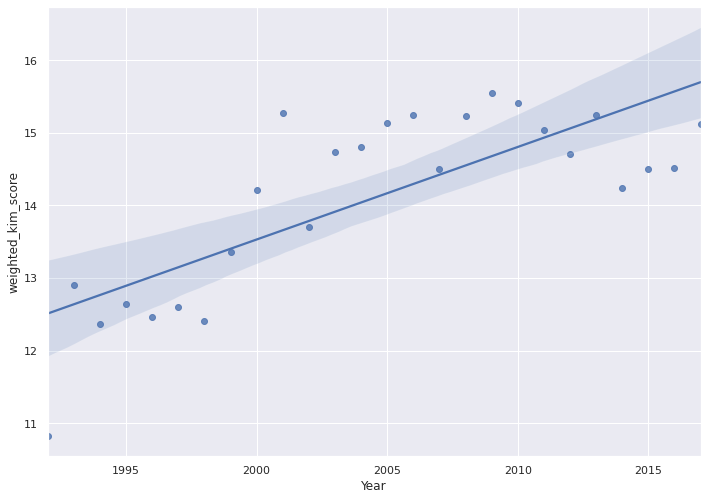

In [38]:
viz_df = percentages.reset_index()
viz_df['weighted_kim_score'] = viz_df['weighted_kim_score'].astype('float64')
viz_df['Year'] = viz_df['Year'].astype('int32')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.regplot(x=viz_df['Year'],y=viz_df['weighted_kim_score'],ci=95)

#### We see a clear positive slope which indicates an increase in overall KIM scores over the years. Since this is the weighted KIM scores, where we've accounted for the variability of percentage distribution, we can conclude that there has been a ratings creep. 

### Plotting category wise scores

In [39]:
# Category wise
cols_to_process = ['Sex','Violence','Language']
for col in cols_to_process:
    post92[col] = post92[col].astype('int32')

post92['weighted_sex'] = post92.apply(calculate_weighted_score,args=[7], axis=1)
post92['weighted_violence'] = post92.apply(calculate_weighted_score,args=[8], axis=1)
post92['weighted_language'] = post92.apply(calculate_weighted_score,args=[9], axis=1)

percentages['weighted_sex_score'] = post92.groupby('Year')['weighted_sex'].mean()
percentages['weighted_violence_score'] = post92.groupby('Year')['weighted_violence'].mean()
percentages['weighted_language_score'] = post92.groupby('Year')['weighted_language'].mean()

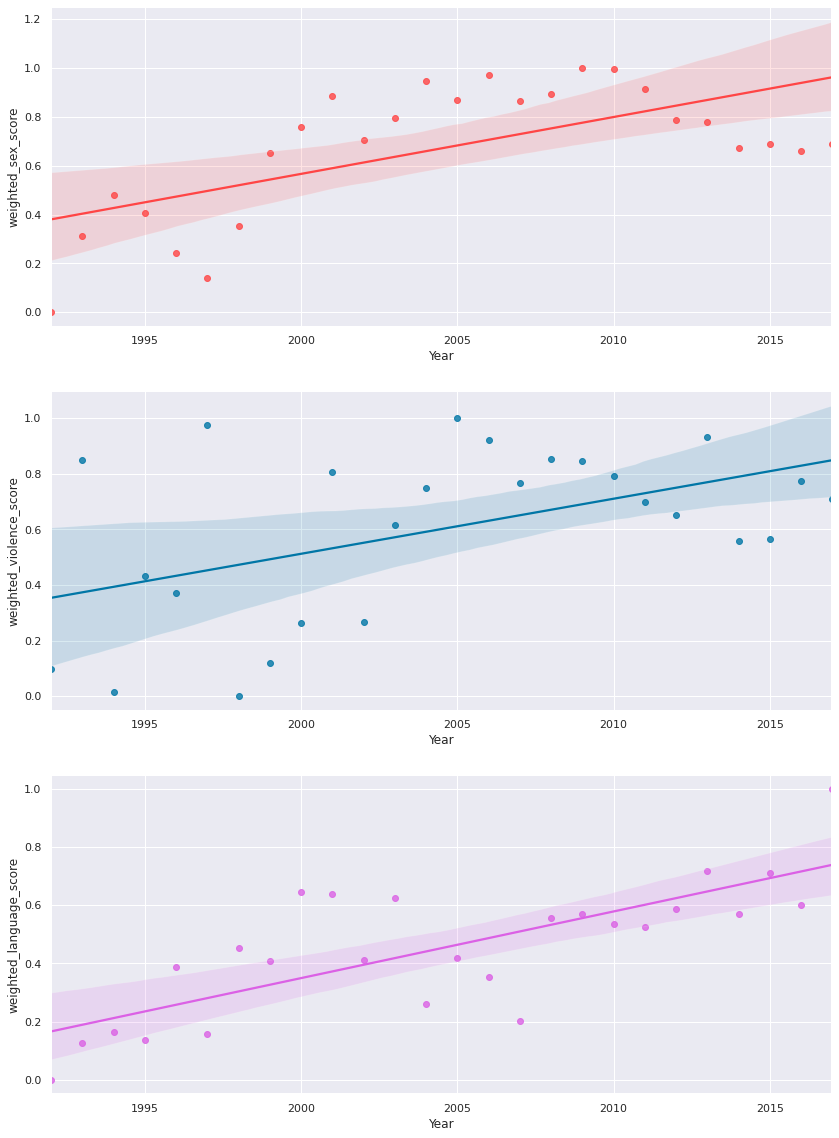

In [51]:
# in notebook
cols_to_graph = ['weighted_sex_score','weighted_violence_score','weighted_language_score']

temp_viz_df = percentages.reset_index()
temp_viz_df['Year'] = temp_viz_df['Year'].astype('int32')

# normalizing
temp_viz_df[cols_to_graph] = temp_viz_df[cols_to_graph].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

fig, ax = plt.subplots(3,figsize=(14,20))
colors = ['#FF4545','#0076a6','#DB61E5']
    
for i, col in enumerate(cols_to_graph):
    

    plt.rcParams['axes.linewidth'] = 2
    sns.regplot(x=temp_viz_df['Year'],y=temp_viz_df[col],ci=95,ax=ax[i],color=colors[i])